# 章節 8：觀察者偏誤（Observer Bias）

## 8.4 預測等待時間

先預備上章節的程式碼，程式碼後正文開始。

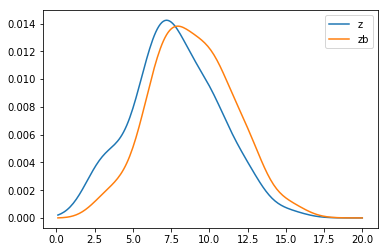

真實資料 z 平均值： 7.774838266350817
乘客偏差資料 zb 平均值： 8.89676868776294


In [15]:
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
import thinkbayes as tb

OBSERVED_GAP_TIMES = [
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
]


def plot_dist(dist):
    x, y = zip(*sorted(dist.Items()))
    plt.plot(x, y)

class TruthGaps(tb.Pmf):
    
    def __init__(self, gaps, x=np.linspace(0.1, 20, 200)):
        super().__init__(x)
        self.kde = gaussian_kde(gaps_min)
        self.make_pmf(x)
        
    def make_pmf(self, x):
        for interval in x:
            self.Set(interval, self.evaluate(interval))
        
        self.Normalize()
        

    def evaluate(self, x):
        return self.kde(x)[0]
            
gaps_min = np.array(OBSERVED_GAP_TIMES)/60.0
z = TruthGaps(gaps_min)


def BiasPmf(pmf):
    # pmf 是真實資料的分佈
    new_pmf = pmf.Copy()
    
    # 在迴圈裡面，我們對每個數值的機率乘上數值本身，x，也就是被觀察到的可能性與 x 成正比
    for x, p in pmf.Items():
        new_pmf.Mult(x, x)
        
    # 正規化
    new_pmf.Normalize()
    
    #new_pmf 是乘客偏差的分佈
    return new_pmf

def MakeRange(low, high):
    sec = range(low, int(high*60)+1) # 每秒
    return np.array(sec)/60


def MakeUniformPmf(low, high):
    # low, high 為均勻分佈的範圍（包含兩端點）
    pmf = tb.Pmf()
    for x in MakeRange(low, high): # 產生所有可能的時間數值（分鐘）
        pmf.Set(x, 1)
    
    pmf.Normalize()
    return pmf


def PmfOfWaitTime(pmf_zb):
    
    # metapmf 將每個均勻分佈對應其班距的機率
    metapmf = tb.Pmf()
    for gap, prob in pmf_zb.Items():
        uniform = MakeUniformPmf(0, gap) # 產生均勻分佈
        metapmf.Set(uniform, prob)
    
    # 在 5.6 小節看到，用 MakeMixture 計算混合體
    pmf_y = tb.MakeMixture(metapmf)
        
    return pmf_y


class WaitTimeCalculator(object):
    
    def __init__(self, pmf_z):
        # pmf_z 是真實班距的分佈
        self.pmf_z = pmf_z
        
        # pmf_zb 是觀察者偏誤的班距分佈
        self.pmf_zb = BiasPmf(pmf_z)
        
        # pmf_y 是等待時間的分佈
        self.pmf_y = PmfOfWaitTime(self.pmf_zb)
        
        # pmf_y 是經過時間的分佈，跟等待時間分佈等同
        self.pmf_x = self.pmf_y.Copy()


zb = BiasPmf(z)

plot_dist(z)
plot_dist(zb)
plt.legend(["z", "zb"])
plt.show()
print("真實資料 z 平均值：", z.Mean())
print("乘客偏差資料 zb 平均值：", zb.Mean())

回到原本的問題：假設我到月台後看到 10 個人在等待，我預期下班火車多久會到達？

一如往常，我們從問題最簡單的版本開始，再來改進。假設給定真實班距分佈 z ，而且我們也知道乘客抵得的頻率 λ ，每分鐘 2 名乘客。

我們能用以下步驟：

1. 用分佈 z 計算 zp 班距被乘客觀察到的分佈。
2. 用目前月台上的乘客預測 x 經過時間的分佈。
3. 最後用 y = zp - x 的關係式來找到 y 等待時間的分佈。

步驟一：在考慮乘客數量之前，用 WaitTimeCalculator 類別封裝分佈 zp, x 和 y，

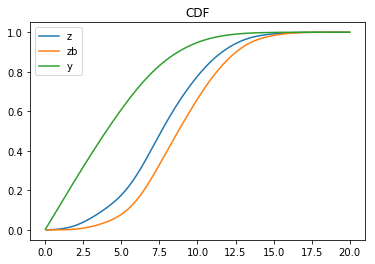

In [16]:
wait_time = WaitTimeCalculator(z)

plot_dist(wait_time.pmf_z.MakeCdf())
plot_dist(wait_time.pmf_zb.MakeCdf())
plot_dist(wait_time.pmf_y.MakeCdf())
plt.title("CDF")
plt.legend(["z", "zb", "y"])
plt.show()

接下來用 ElapsedTimeEstimator 方法封裝 x 等待時間的後驗分佈，以及 y 的預測分佈。

請從下格的最下方執行點開始並且搭配註解閱讀。

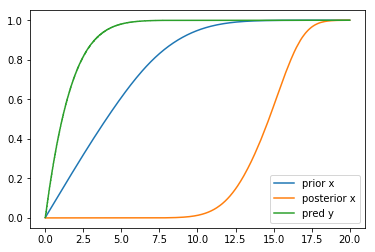

預測等待 <= 2.5 分鐘的機率： 0.8173842887780048


In [28]:
def RemoveNegatives(pmf):
    for val in pmf.Values():
        if val < 0:
            pmf.Remove(val) # 做 dictionary 的移除 key 操作
    pmf.Normalize()


    
def PredictWaitTime(pmf_zb, pmf_x):
    # 減號運算子會呼叫 Pmf.__sub__ 的方法
    # Pmf.__sub__ 會找出所有 zb 和 x 數值的相減配對，並將其對應的相乘機率加總
    pmf_y = pmf_zb - pmf_x
    
    # pmf_y 不可能會有負的數值。例如班距為 5 分鐘，你不可能等超過 5 分鐘車才來。（除非你等下一班）
    # RemoveNegatives 就是移除 pmf_y 分佈中負的數值並且重新正規化
    RemoveNegatives(pmf_y)
    return pmf_y



class Elapsed(tb.Suite):
    
    def Likelihood(self, data, hypo):
        lam, num_passengers = data # 將資料拆解(unpacking)
        time_elapsed = hypo
        
        # 似然性函數為 Poisson 分佈
        # 意義為在不同經過時間看到 num_passengers 數量的機率
        like = tb.EvalPoissonPmf(num_passengers, time_elapsed*lam) 
        return like
    

class ElapsedTimeEstimator(object):
    
    def __init__(self, wtc, lam, num_passengers):
        # wtc: 上方的 WaitTimeCalculator 物件
        # lam: 乘客抵達頻率（人/秒）
        # num_passengers: 月台乘客數
        
        # x 的先驗分佈，就是來自 WaitTimeCalculator 的 pmf_x
        self.prior_x = Elapsed(wtc.pmf_x)
        
        # x 的後驗分佈
        self.post_x = self.prior_x.Copy()
        
        # 這邊的資料是由 (乘客到達頻率, 目前月台乘客數) 所構成
        self.post_x.Update((lam, num_passengers)) # 參考 Elapsed 類別的 Likelihood 方法
        
        # y = zb - x
        self.pmf_y = PredictWaitTime(wtc.pmf_zb, self.post_x)

# lam 每分鐘兩人 = 每秒 2.0/60 人
ete = ElapsedTimeEstimator(wait_time, lam=2.0/60, num_passengers=15)

plot_dist(ete.prior_x.MakeCdf())
plot_dist(ete.post_x.MakeCdf())
plot_dist(ete.pmf_y.MakeCdf())
plt.legend(["prior x", "posterior x", "pred y"])
plt.show()

print("預測等待 <= 2.5 分鐘的機率：", ete.pmf_y.MakeCdf().Prob(2.5))

上圖 x 的後驗分佈（posterior x）為觀察到 15 名乘客在月台隨經過時間（分鐘）的機率。有很大的機會上次火車離開約 12-17 分鐘。

下班車在 2.5 分鐘之內來的機率約有 80% 的信心。